In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import time

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

Using TensorFlow backend.


In [3]:
def scale_training_data(X_train, Y_train):
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    
    X_train_s = x_scaler.fit_transform(X_train)
    Y_train_s = y_scaler.fit_transform(Y_train)
    
    return X_train_s, Y_train_s, x_scaler, y_scaler

In [4]:
def train_test_split(X_train, Y_train, train_portion):

    x_train = X_train[0:int(n_timesteps*train_portion),:]
    x_test = X_train[int(n_timesteps*(train_portion)):,:]
    y_train = Y_train[0:int(n_timesteps*train_portion),:]
    y_test = Y_train[int(n_timesteps*(train_portion)):,:]
    
    return x_train, y_train, x_test, y_test

In [5]:
def baseline_model(input_dim, output_dim, height):
    model = Sequential()
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    adam = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=adam)
    
    earlystop = EarlyStopping(monitor='loss', min_delta=0.000001, patience=10, verbose=1, mode='auto')
    callback_list = [earlystop]
    return model, callback_list

In [24]:
def prepare_training_data(df_F, df_D, df_Dt, d, t):

    D = df_D.values[:,-1]
    Dt = df_Dt.values[:,-1]
    F = df_F.values[:,0]
    dim = len(D)

    n_timesteps = dim
    n_nodes = 1
    
    x = np.linspace(0,1, n_nodes)

    X_train = np.zeros([n_timesteps-d, 3*d*n_nodes])
    Y_train = np.zeros([n_timesteps-d, 2*n_nodes])


    for k in range(n_timesteps-d):

        bulk = 0
        X_train[k, bulk:bulk + d] = F[t-d:t]    
        bulk += d

        X_train[k, bulk:bulk + d] = D[t-d:t]
        bulk += d

        X_train[k, bulk: bulk + d] = Dt[t-d:t]
        bulk += d

        Y_train[k, 0] = D[t]
        Y_train[k, 1] = Dt[t]
        t += 1
        
    return X_train, Y_train, n_timesteps, n_nodes, x

In [25]:
def get_error(predictions, y_test):
    error = 0
    for i in range(len(predictions[:,0])):
        error += np.trapz((y_test[i,:] - predictions[i,:])**2, x)
    return error

In [26]:
def independent_predictions(x_test):

    input_i = np.copy(x_test[0,:])

    dz = np.copy(input_i[d*n_nodes:])

    dz = np.reshape(dz, (n_nodes*2, d))


    #dzt = np.copy(input_i[d+1+n_nodes*d:])
    #dzt = np.reshape(dzt, (n_nodes, d))

    preds = np.zeros([len(x_test[:,0])-1, n_nodes*2])
    force = np.copy(x_test[:, 0:d*n_nodes])

    for k in range(len(x_test[:,0])-1):


        pred = model.predict(np.reshape(input_i,(1,len(input_i))))
        preds[k, :] = pred

        input_i[0:d*n_nodes] = force[i+1,:]

        dz = np.delete(dz, 0, 1)
        dz = np.concatenate((dz, np.reshape(pred[0,:], (1,n_nodes*2)).T), axis=1)
        #dz[0,:] = np.zeros(d)
        #dzt = np.delete(dzt, 0, 1)
        #dzt = np.concatenate((dzt, np.reshape(pred[0,n_nodes:], (1, n_nodes)).T), axis=1)
        #dzt[0,:] = np.zeros(n_nodes)
        input_i[d*n_nodes:] = np.reshape(dz, (1, n_nodes*d*2))[0]
        #input_i[d+1+n_nodes*d:] = np.reshape(dzt, (1, n_nodes*d))[0]
    
    return preds


In [48]:
#Independent predictions

input_i = x_test[0,:]
print(input_i)
input_2 = x_test[1,:]

pred1 =model.predict(input_i.reshape((1,len(input_i))))
print(pred1)
print(y_test[0, :])

input_i[0:2] = x_test[1,0:2]
input_i[2:4] = np.array([input_i[3], pred1[0,0]])
input_i[4:] = np.array([input_i[5], pred1[0,1]])

print(input_i)
print(input_2)

pred2 =model.predict(input_i.reshape((1,len(input_i))))
print(pred2)
print(y_test[1,:])


[ 0.41343075  0.41379101  0.51734066  0.52008414  0.52673045  0.52048457]
[[ 0.52126193  0.51329923]]
[ 0.51858086  0.51959704]
[ 0.41343075  0.41379101  0.52008414  0.52126193  0.52048457  0.51329923]
[ 0.41343075  0.41379101  0.51734066  0.51858086  0.52673045  0.51959704]
[[ 0.52288419  0.50632507]]
[ 0.51875803  0.51240511]


In [46]:
[input_i[3], pred1[0]]

[0.51734065642025073, array([ 0.52008414,  0.52048457], dtype=float32)]

In [28]:
########################### TRAIN FEED-FORWARD MODEL #################################

d = 2 #number of steps in "model memory"
t = d
n_batches = 1

t0 = time.time()
for i in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    if i == 0:
        model, callback_list = baseline_model(input_dim, output_dim, 10)
    
    ts = time.time()
    model.fit(x_train, y_train, epochs=100, verbose = 1, callbacks=callback_list)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    total_time = time.time() - t0
    
    info = {'Iteration': i, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)
    

Epoch 1/100
24000/24000 [==============================] - 1s 38us/step - loss: 0.1142
Epoch 2/100
24000/24000 [==============================] - 1s 26us/step - loss: 0.0132
Epoch 3/100
24000/24000 [==============================] - 1s 35us/step - loss: 0.0129
Epoch 4/100
24000/24000 [==============================] - 1s 32us/step - loss: 0.0124
Epoch 5/100
24000/24000 [==============================] - 1s 30us/step - loss: 0.0117
Epoch 6/100
24000/24000 [==============================] - 1s 34us/step - loss: 0.0108
Epoch 7/100
24000/24000 [==============================] - 1s 26us/step - loss: 0.0096
Epoch 8/100
24000/24000 [==============================] - 1s 26us/step - loss: 0.0073
Epoch 9/100
24000/24000 [==============================] - 1s 29us/step - loss: 0.0034
Epoch 10/100
24000/24000 [==============================] - 1s 28us/step - loss: 0.0013
Epoch 11/100
24000/24000 [==============================] - 1s 22us/step - loss: 6.7646e-04
Epoch 12/100
24000/24000 [===========

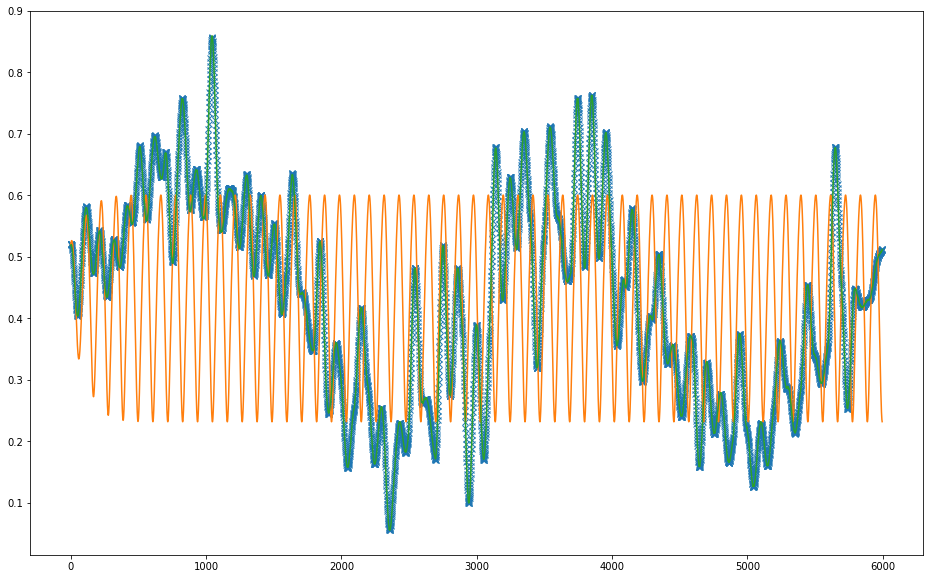

{'Iteration': 0, 'Train error': 0.0, 'Test error': 0.0, 'Independent error': 0.0, 'Training time': 0.0, 'Total time': 3.062101364135742}


In [36]:
######################## TEST FEED-FORWARD MODEL ###########################

t0 = time.time()

for i in range(n_batches):

    df_D = pd.read_csv('C:/Users/endrep/Documents/training_batches/D' + str(i+1) + '.csv')
    df_F = pd.read_csv('C:/Users/endrep/Documents/training_batches/F' + str(i+1) + '.csv')
    df_Dt = pd.read_csv('C:/Users/endrep/Documents/training_batches/Dt' + str(i+1) + '.csv')
    
    X_train, Y_train, n_timesteps, n_nodes, x = prepare_training_data(df_F, df_D, df_Dt, d, t)
    
    X_train_s, Y_train_s, x_scaler, y_scaler = scale_training_data(X_train, Y_train)
    
    x_train, y_train, x_test, y_test = train_test_split(X_train_s, Y_train_s, 0.8)
    
    input_dim = len(X_train[0,:])
    output_dim = len(Y_train[0,:])

    #if i == 0:
    #    model = baseline_model(input_dim, output_dim, 100)
    
    ts = time.time()
    #model.fit(x_train, y_train, epochs=100, verbose = 1)
    training_time = time.time() - ts
    
    pred_train_all = model.predict(x_train)
    pred_train = pred_train_all[:, 0:n_nodes]
    pred_train_u = y_scaler.inverse_transform(pred_train_all)[:, 0:n_nodes]
    
    pred_test_all = model.predict(x_test)
    pred_test = pred_test_all[:, 0:n_nodes]
    pred_test_u = y_scaler.inverse_transform(pred_test_all)[:, 0:n_nodes]
    
    pred_ind_all = independent_predictions(x_test)
    pred_ind = pred_ind_all[:, 0:n_nodes]
    pred_ind_u = y_scaler.inverse_transform(pred_ind_all)[:, 0:n_nodes]
    
    
    training_error = get_error(pred_train, y_train[:,0:n_nodes])
    test_error = get_error(pred_test, y_test[:,0:n_nodes])
    ind_error = get_error(pred_ind, y_test[0:len(pred_ind[:,0]),0:n_nodes])
    
    plt.figure(figsize=(16,10))
    plt.plot(pred_test[:,n_nodes-1], 'x')
    plt.plot(pred_ind[:,n_nodes-1])
    plt.plot(y_test[:, n_nodes-1])
    plt.show()
    
    total_time = time.time() - t0
    
    info = {'Iteration': i, 'Train error': training_error, 'Test error': test_error, 'Independent error': ind_error,
            'Training time': training_time, 'Total time': total_time}
    
    print(info)


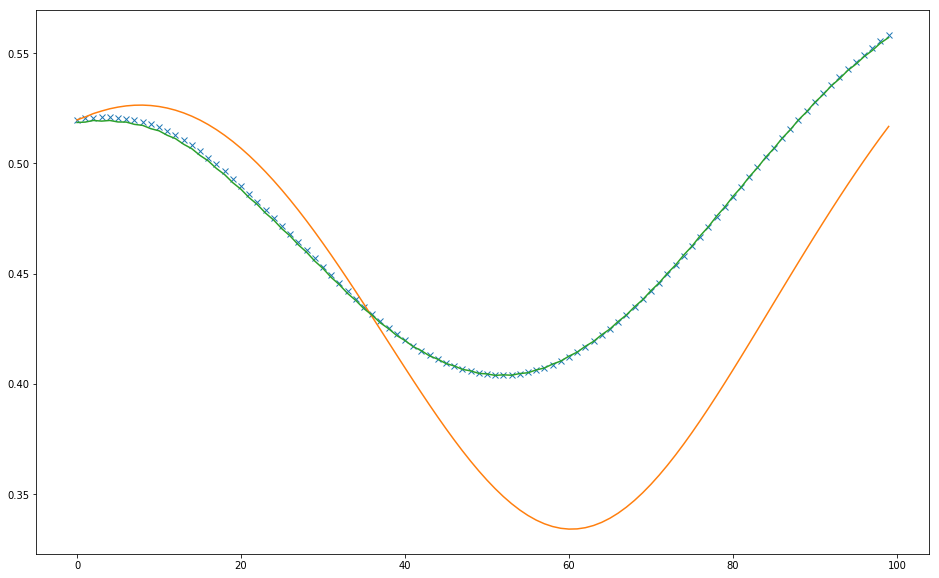

In [30]:
plt.figure(figsize=(16,10))
plt.plot(pred_test[:100,n_nodes-1], 'x')
plt.plot(pred_ind[:100,n_nodes-1])
plt.plot(y_test[0:100, n_nodes-1])
plt.show()

In [247]:
#Export results
np.savetxt("predictions.csv", predictions, delimiter=",")
np.savetxt("preds.csv", preds, delimiter=",")
np.savetxt("y_test.csv", y_test, delimiter=",")